<a href="https://colab.research.google.com/github/danadler-dev/SDA-GA-Article-ALife/blob/main/Submitted_ALife_SDA_GA_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SDA with recombination and mutation instead of concatenation

In [ ]:
 !pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 29.8 MB/s eta 0:00:00


In [ ]:
import random

def mutate(s, base_elements=['A', 'B', 'C'], prob=0.0, rng=random):
    """
    Diffusion-like mutation:
      - With probability `prob`, change EXACTLY ONE random position
        to a different symbol from `base_elements`.
      - Otherwise return `s` unchanged.
    """
    if not s or rng.random() > prob:
        return s

    pos = rng.randrange(len(s))
    old = s[pos]
    choices = [a for a in base_elements if a != old]
    new = rng.choice(choices) if choices else old
    return s[:pos] + new + s[pos+1:]

def recombine(s1, s2, rng=random):
    """
    Splice larger substrings from two parents.
    - Choose random substring from each parent
    - Concatenate them to form the child
    """
    if not s1 and not s2:
        return ""
    if not s1:
        return s2
    if not s2:
        return s1

    # pick substring from s1
    i1, j1 = sorted([rng.randrange(len(s1)), rng.randrange(len(s1))])
    sub1 = s1[i1:j1+1] if j1 >= i1 else s1[i1]

    # pick substring from s2
    i2, j2 = sorted([rng.randrange(len(s2)), rng.randrange(len(s2))])
    sub2 = s2[i2:j2+1] if j2 >= i2 else s2[i2]

    child = sub1 + sub2
    return child

In [ ]:
# Custom Stability vs Unconstrained Comparison

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict
from tqdm.notebook import tqdm

# PatternInstance class for tracking pattern lifetimes
class PatternInstance:
    def __init__(self, pattern, creation_time, expiration_time):
        self.pattern = pattern
        self.creation_time = creation_time
        self.expiration_time = expiration_time

    def is_expired(self, current_time):
        return current_time >= self.expiration_time

def run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # None for unconstrained, dict for custom stability
    replenishment_rate=5,
    interactions_per_gen=50,
    generations=100,
    selection_mode="frequency_proportional",  # "uniform" or "frequency_proportional"
    name="Simulation",
    init_pop=None,
    init_hist=None,
    seed=42,
    use_recomb=False,
    mutation_prob=0.0,
):
    """Run a simulation with given parameters."""
    # Set random seed
    random.seed(seed)
    np.random.seed(seed)

    # Initialize
    population = [] if init_pop is None else init_pop

    # Default stability function (all patterns have stability 1)
    if stability is None:
        stability_function = lambda pattern: 1
        name = "Unconstrained System"
    else:
        # Custom stability function using provided dictionary
        def stability_function(pattern):
            return stability.get(pattern, 1)  # Default to 1 if not specified
        name = "Custom Stability System"

    # Add initial base elements
    if init_pop is None:
      for element in base_elements:
          element_stability = stability_function(element)
          for _ in range(replenishment_rate):
              population.append(PatternInstance(element, 0, element_stability))
    else:
      for p in population:
          #if a prior population was passed in - reset its expiration relative to now
          p.expiration_time -= p.creation_time

    # Track history
    history = {} if init_hist is None else init_hist
    history['populations'] = []
    history['entropy'] = []
    history['total_counts'] = []
    history['pattern_counts'] = []

    # Run simulation
    for t in tqdm(range(1, generations + 1), desc=name):
        # 1. Remove expired patterns
        population = [p for p in population if not p.is_expired(t)]

        # 2. Replenish base elements
        for element in base_elements:
            element_stability = stability_function(element)
            for _ in range(replenishment_rate):
                population.append(PatternInstance(element, t, t + element_stability))

        # 3. Perform interactions
        if population and len(population) >= 2:
            # Get current pattern distribution for selection
            pattern_types = [p.pattern for p in population]
            pattern_counts = Counter(pattern_types)

            for _ in range(interactions_per_gen):
                # Select patterns based on selection mode
                if selection_mode == "frequency_proportional":
                    # Select patterns based on their frequency
                    selected_patterns = random.choices(
                        list(pattern_counts.keys()),
                        weights=[pattern_counts[p] for p in pattern_counts],
                        k=2
                    )

                    # Find instances of those patterns
                    p1_pattern, p2_pattern = selected_patterns
                    p1_instances = [p for p in population if p.pattern == p1_pattern]
                    p2_instances = [p for p in population if p.pattern == p2_pattern]

                    # Select random instances
                    p1 = random.choice(p1_instances)
                    if p1_pattern == p2_pattern and len(p1_instances) > 1:
                        p2_instances.remove(p1)
                    p2 = random.choice(p2_instances)
                else:
                    # Uniform selection (random)
                    p1, p2 = random.sample(population, 2)

                # Form new pattern with recombination or simple concat
                if use_recomb:
                  new_pattern = recombine(p1.pattern, p2.pattern)
                  # Apply optional mutation
                  new_pattern = mutate(new_pattern,
                            base_elements=base_elements,
                            prob=mutation_prob)
                else:
                  new_pattern = p1.pattern + p2.pattern

                # Skip if too long
                if len(new_pattern) > 50:
                    continue

                # Add new pattern with stability
                new_stability = stability_function(new_pattern)
                population.append(PatternInstance(new_pattern, t, t + new_stability))

        # 4. Record state
        pattern_counts = Counter(p.pattern for p in population)
        total_count = len(population)

        # Calculate entropy
        if total_count > 0:
            probs = [count / total_count for count in pattern_counts.values()]
            entropy = -sum(p * np.log2(p) for p in probs if p > 0)
        else:
            entropy = 0

        # Store metrics
        history['entropy'].append(entropy)
        history['pattern_counts'].append(len(pattern_counts))
        history['total_counts'].append(total_count)
        history['populations'].append(dict(pattern_counts))

    # Return results
    return {
        'name': name,
        'history': history,
        'final_population': dict(Counter(p.pattern for p in population)),
        'final_raw_population': population  # Include raw population data for analysis
    }

def compare_simulations(results_list):
    """Create comparison visualizations between simulations."""
    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Entropy comparison
    for result in results_list:
        axs[0, 0].plot(result['history']['entropy'], label=result['name'], linewidth=2)

    axs[0, 0].set_xlabel('Generation')
    axs[0, 0].set_ylabel('Shannon Entropy')
    axs[0, 0].set_title('Entropy Comparison')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # 2. Pattern counts
    for result in results_list:
        axs[0, 1].plot(result['history']['pattern_counts'], label=result['name'], linewidth=2)

    axs[0, 1].set_xlabel('Generation')
    axs[0, 1].set_ylabel('Unique Pattern Count')
    axs[0, 1].set_title('Pattern Diversity')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 3. Top patterns in first simulation
    if results_list and 'final_population' in results_list[0]:
        top_patterns = sorted(results_list[0]['final_population'].items(), key=lambda x: x[1], reverse=True)[:8]
        if top_patterns:
            patterns, counts = zip(*top_patterns)
            display_patterns = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns]

            bars = axs[1, 0].bar(range(len(display_patterns)), counts, color='skyblue')
            axs[1, 0].set_xticks(range(len(display_patterns)))
            axs[1, 0].set_xticklabels(display_patterns, rotation=45, ha='right')
            axs[1, 0].set_xlabel('Pattern')
            axs[1, 0].set_ylabel('Count')
            axs[1, 0].set_title(f'Top Patterns ({results_list[0]["name"]})')

            # Add percentage labels
            total = sum(counts)
            for i, bar in enumerate(bars):
                height = bar.get_height()
                percentage = (counts[i] / total * 100) if total > 0 else 0
                axs[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                             f"{percentage:.1f}%", ha='center', va='bottom', rotation=0)

    # 4. Top patterns in second simulation
    if len(results_list) > 1 and 'final_population' in results_list[1]:
        top_patterns = sorted(results_list[1]['final_population'].items(), key=lambda x: x[1], reverse=True)[:8]
        if top_patterns:
            patterns, counts = zip(*top_patterns)
            display_patterns = [p[:8] + ('...' if len(p) > 8 else '') for p in patterns]

            # Use different color scheme for custom stability system
            bar_colors = plt.cm.viridis(np.linspace(0, 1, len(display_patterns)))

            bars = axs[1, 1].bar(range(len(display_patterns)), counts, color=bar_colors)
            axs[1, 1].set_xticks(range(len(display_patterns)))
            axs[1, 1].set_xticklabels(display_patterns, rotation=45, ha='right')
            axs[1, 1].set_xlabel('Pattern')
            axs[1, 1].set_ylabel('Count')
            axs[1, 1].set_title(f'Top Patterns ({results_list[1]["name"]})')

            # Add percentage labels
            total = sum(counts)
            for i, bar in enumerate(bars):
                height = bar.get_height()
                percentage = (counts[i] / total * 100) if total > 0 else 0
                axs[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                             f"{percentage:.1f}%", ha='center', va='bottom', rotation=0)

    plt.suptitle("Simulation Comparison", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    return fig


Running unconstrained simulation...


Unconstrained System:   0%|          | 0/600 [00:00<?, ?it/s]


Running custom stability simulation...


Custom Stability System:   0%|          | 0/600 [00:00<?, ?it/s]


Key Metrics:
Final entropy (Unconstrained): 6.3556
Final entropy (Custom Stability): 2.8049
Entropy reduction: 3.5507

Top patterns in Unconstrained system:
  A: 5 (4.35%)
  B: 5 (4.35%)
  C: 5 (4.35%)
  CA: 3 (2.61%)
  AA: 3 (2.61%)

Top patterns in Custom Stability system:
  ABCABA: 388 (59.78%)
  ABA: 68 (10.48%)
  ABC: 37 (5.70%)
  AB: 29 (4.47%)
  B: 10 (1.54%)


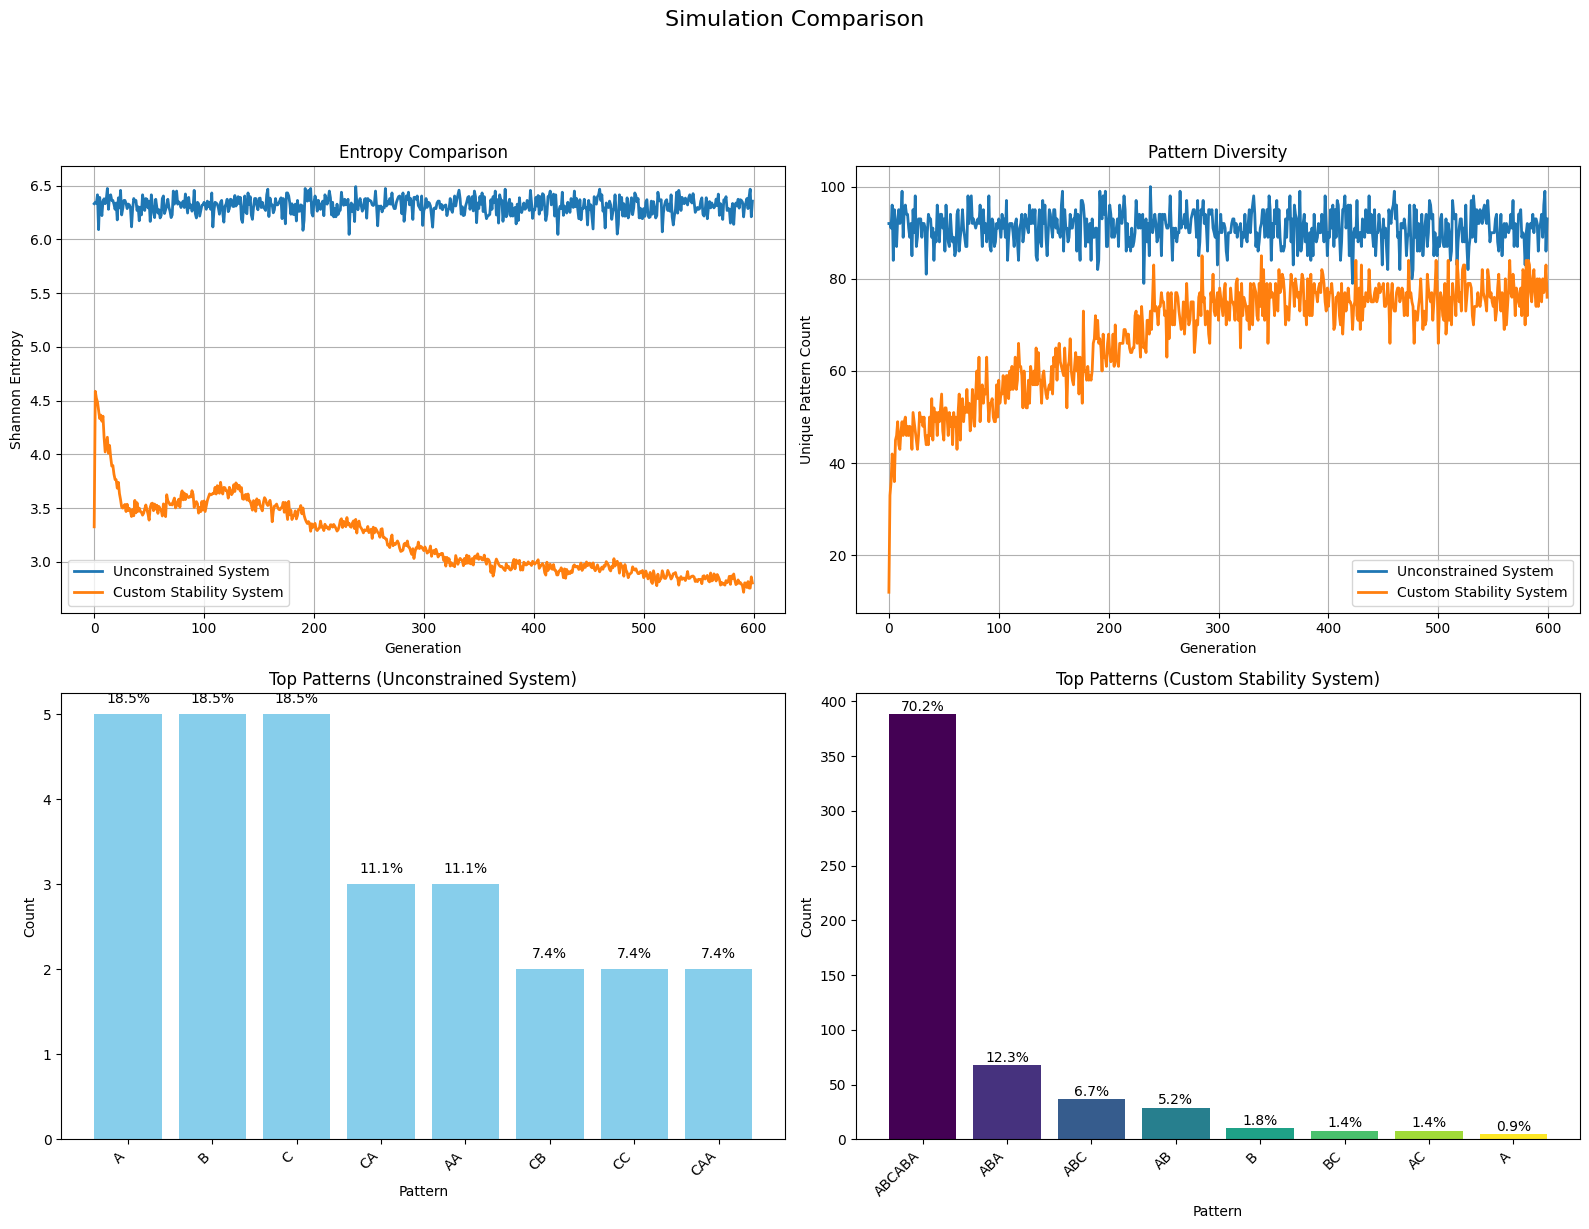

In [ ]:
# Simulation with one dominant pattern

custom_stability = {
    "AB": 30, "BC": 30, "ABC": 30, "ABA": 30, "ABCABA": 200,  # High stability for specific compounds
    "AC": 10, "A": 1, "B": 2, "C": 1  # Lower stability for others
}

replenishment_rate = 5
interactions_per_gen=100
generations=600

# Run both simulations
print("Running unconstrained simulation...")
unconstrained_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=None,  # No specific stability values
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="uniform",  # Random selection
    seed=42
)

print("\nRunning custom stability simulation...")
custom_result = run_simulation(
    base_elements=['A', 'B', 'C'],
    stability=custom_stability,
    replenishment_rate=replenishment_rate,
    interactions_per_gen=interactions_per_gen,
    generations=generations,
    selection_mode="frequency_proportional",  # Selection based on pattern frequency
    seed=42,
    use_recomb=True,
    mutation_prob=0.01
)

# Create comparison figure
fig = compare_simulations([unconstrained_result, custom_result])

# Print key metrics
print("\nKey Metrics:")
print(f"Final entropy (Unconstrained): {unconstrained_result['history']['entropy'][-1]:.4f}")
print(f"Final entropy (Custom Stability): {custom_result['history']['entropy'][-1]:.4f}")
print(f"Entropy reduction: {unconstrained_result['history']['entropy'][-1] - custom_result['history']['entropy'][-1]:.4f}")

# Save the figure
fig.savefig('custom_stability_comparison.png', dpi=300, bbox_inches='tight')

# Print top patterns in each system
print("\nTop patterns in Unconstrained system:")
for pattern, count in sorted(unconstrained_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(unconstrained_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

print("\nTop patterns in Custom Stability system:")
for pattern, count in sorted(custom_result['final_population'].items(), key=lambda x: x[1], reverse=True)[:5]:
    total = sum(custom_result['final_population'].values())
    percentage = (count / total * 100) if total > 0 else 0
    print(f"  {pattern}: {count} ({percentage:.2f}%)")

In [ ]:
from rdkit import Chem, RDLogger
from rdkit.Chem import BRICS, Descriptors
from rdkit.Chem.rdchem import BondType
from rdkit.Chem.Draw import MolsToGridImage
import random

# Quiet RDKit chatter
RDLogger.DisableLog("rdApp.*")

# -----------------------------
# RNG control for reproducibility
# -----------------------------
def set_rng(seed=None):
    random.seed(seed)

# -----------------------------
# Utilities & sanity filters
# -----------------------------
def _largest_fragment(m):
    frags = Chem.GetMolFrags(m, asMols=True, sanitizeFrags=True)
    return max(frags, key=lambda x: x.GetNumAtoms()) if frags else m

def _has_forbidden_hetero_hetero_single_bond(m):
    # Ban O–O / N–N / N–O single bonds
    for b in m.GetBonds():
        if b.GetBondType() != BondType.SINGLE:
            continue
        aZ = b.GetBeginAtom().GetAtomicNum()
        bZ = b.GetEndAtom().GetAtomicNum()
        heteros = {7, 8}
        if (aZ in heteros) and (bZ in heteros):
            return True
    return False

def _quick_filter(m):
    """Cheap plausibility gate; returns filtered mol or None."""
    try:
        m = Chem.AddHs(m); m = Chem.RemoveHs(m)
        m = _largest_fragment(m)
        if _has_forbidden_hetero_hetero_single_bond(m):
            return None
        mw = Descriptors.MolWt(m)
        logp = Descriptors.MolLogP(m)
        if not (60 <= mw <= 900):
            return None
        if not (-3 <= logp <= 8):
            return None
        return m
    except Exception:
        return None

# -----------------------------
# Strict random-splice fallback
# -----------------------------
def _is_good_splice_atom(a):
    if a.GetIsAromatic(): return False
    if a.IsInRing(): return False
    Z = a.GetAtomicNum()
    if Z not in (6, 7, 8): return False  # C/N/O only
    hyb = a.GetHybridization()
    if hyb not in (Chem.HybridizationType.SP2, Chem.HybridizationType.SP3):
        return False
    try:
        imp = a.GetImplicitValence()
    except Exception:
        imp = 0
    if not imp or imp <= 0: return False
    if a.GetDegree() >= 4: return False
    return True

def _attachable_atoms_strict(mol):
    return [a.GetIdx() for a in mol.GetAtoms() if _is_good_splice_atom(a)]

def _random_splice_join_strict(molA, molB, max_tries=64):
    a_idxs = _attachable_atoms_strict(molA)
    b_idxs = _attachable_atoms_strict(molB)
    if not a_idxs or not b_idxs:
        return None
    offset = molA.GetNumAtoms()
    for _ in range(max_tries):
        ai = random.choice(a_idxs)
        bi = random.choice(b_idxs)
        aZ = molA.GetAtomWithIdx(ai).GetAtomicNum()
        bZ = molB.GetAtomWithIdx(bi).GetAtomicNum()
        if (aZ in (7, 8)) and (bZ in (7, 8)):  # forbid hetero–hetero join
            continue
        combo = Chem.CombineMols(molA, molB)
        em = Chem.EditableMol(combo)
        em.AddBond(ai, offset + bi, BondType.SINGLE)
        cand = em.GetMol()
        try:
            Chem.SanitizeMol(cand)
            A = cand.GetAtomWithIdx(ai)
            B = cand.GetAtomWithIdx(offset + bi)
            if A.GetDegree() > 4 or B.GetDegree() > 4:
                continue
            cand = _quick_filter(cand)
            if cand is not None:
                return cand
        except Exception:
            continue
    return None

# -----------------------------
# Aromatic-substitution fallback (for pure aromatics)
# -----------------------------
def _aromatic_attachable_atoms(mol):
    return [a.GetIdx() for a in mol.GetAtoms()
            if a.GetAtomicNum()==6 and a.GetIsAromatic() and a.GetTotalNumHs()>=1]

def _aliphatic_attachable_atoms_for_aromatic_join(mol):
    idxs = []
    for a in mol.GetAtoms():
        if a.GetAtomicNum()!=6: continue
        if a.GetIsAromatic(): continue
        if a.IsInRing(): continue
        hyb = a.GetHybridization()
        if hyb not in (Chem.HybridizationType.SP2, Chem.HybridizationType.SP3):
            continue
        try:
            imp = a.GetImplicitValence()
        except Exception:
            imp = 0
        if not imp or imp <= 0: continue
        if a.GetDegree() >= 4: continue
        idxs.append(a.GetIdx())
    return idxs

def _aromatic_substitution_join(parent_aromatic, frag, max_tries=64):
    a_idxs = _aromatic_attachable_atoms(parent_aromatic)
    b_idxs = _aliphatic_attachable_atoms_for_aromatic_join(frag)
    if not a_idxs or not b_idxs:
        return None
    offset = parent_aromatic.GetNumAtoms()
    for _ in range(max_tries):
        ai = random.choice(a_idxs)
        bi = random.choice(b_idxs)
        combo = Chem.CombineMols(parent_aromatic, frag)
        em = Chem.EditableMol(combo)
        em.AddBond(ai, offset + bi, BondType.SINGLE)
        cand = em.GetMol()
        try:
            Chem.SanitizeMol(cand)
            A = cand.GetAtomWithIdx(ai)
            B = cand.GetAtomWithIdx(offset + bi)
            if A.GetDegree() > 4 or B.GetDegree() > 4:
                continue
            cand = _quick_filter(cand)
            if cand is not None:
                return cand
        except Exception:
            continue
    return None

def _is_pure_aromatic_ring(m):
    ri = m.GetRingInfo()
    if ri.NumRings()==0: return False
    return all(a.GetIsAromatic() for a in m.GetAtoms())

# -----------------------------
# BRICS attempt (returns child mol or None)
# -----------------------------
def _try_brics_build(parent_mol, fragment_pool_mols, max_tries=64, p_insert=0.5):
    try:
        parent_frags = list(BRICS.BRICSDecompose(parent_mol))
    except Exception:
        parent_frags = []
    if len(parent_frags) <= 1:
        return None

    pool = []
    for fm in fragment_pool_mols:
        try:
            Chem.SanitizeMol(fm)
            pool.append(fm)
        except Exception:
            pass

    for _ in range(max_tries):
        try:
            if pool and random.random() < p_insert:
                k = min(len(parent_frags), random.randint(1, min(3, len(parent_frags))))
                parts = [Chem.MolFromSmiles(s) for s in random.sample(parent_frags, k=k)]
                parts.append(random.choice(pool))
            else:
                parts = [Chem.MolFromSmiles(s) for s in parent_frags]

            parts = [p for p in parts if p is not None]
            if len(parts) < 2:
                continue
            for p in parts:
                Chem.SanitizeMol(p)

            gen = BRICS.BRICSBuild(parts)
            child = next(iter(gen), None)
            if child is None:
                continue
            Chem.SanitizeMol(child)
            child = _quick_filter(child)
            if child is not None:
                return child
        except Exception:
            continue
    return None

# -----------------------------
# Public: mutation (BRICS-first; strict splice; aromatic fallback for pure aromatics)
# -----------------------------
def brics_mutate(smi, base_elements, p_insert=0.5, max_tries=64):
    parent = Chem.MolFromSmiles(smi)
    if parent is None:
        return None

    pool_mols = []
    for fs in fragment_pool:
        m = Chem.MolFromSmiles(fs)
        if m is not None:
            pool_mols.append(m)

    # 1) BRICS attempt
    child_mol = _try_brics_build(parent, pool_mols, max_tries=max_tries, p_insert=p_insert)
    if child_mol is not None:
        return Chem.MolToSmiles(child_mol, isomericSmiles=True)

    # 2) Strict random splice to a random pool fragment
    if pool_mols:
        for _ in range(max_tries):
            frag = random.choice(pool_mols)
            out = _random_splice_join_strict(parent, frag, max_tries=16)
            if out is not None:
                return Chem.MolToSmiles(out, isomericSmiles=True)

    # 3) Aromatic-substitution fallback for pure aromatics (e.g., benzene)
    if _is_pure_aromatic_ring(parent) and pool_mols:
        for frag in random.sample(pool_mols, k=min(len(pool_mols), 16)):
            out = _aromatic_substitution_join(parent, frag, max_tries=32)
            if out is not None:
                return Chem.MolToSmiles(out, isomericSmiles=True)

    return None

# -----------------------------
# Public: crossover (BRICS-first; strict splice fallback)
# -----------------------------
def brics_crossover_simple(smiA, smiB, max_tries=64):
    A = Chem.MolFromSmiles(smiA); B = Chem.MolFromSmiles(smiB)
    if A is None or B is None:
        return None

    try:
        frA = list(BRICS.BRICSDecompose(A))
    except Exception:
        frA = []
    try:
        frB = list(BRICS.BRICSDecompose(B))
    except Exception:
        frB = []

    if (len(frA) > 1) or (len(frB) > 1):
        parts = [Chem.MolFromSmiles(s) for s in (frA + frB)]
        parts = [p for p in parts if p is not None]
        ok_parts = []
        for p in parts:
            try:
                Chem.SanitizeMol(p)
                ok_parts.append(p)
            except Exception:
                pass
        for _ in range(max_tries):
            try:
                gen = BRICS.BRICSBuild(ok_parts)
                child = next(iter(gen), None)
                if child is None:
                    continue
                Chem.SanitizeMol(child)
                child = _quick_filter(child)
                if child is not None:
                    return Chem.MolToSmiles(child, isomericSmiles=True)
            except Exception:
                continue

    # Fallback: strict random splice between A and B
    child = _random_splice_join_strict(A, B, max_tries=max_tries)
    if child is not None:
        return Chem.MolToSmiles(child, isomericSmiles=True)
    return None

# -----------------------------
# Visualization helpers
# -----------------------------
def show_mutation_pairs(parents, children, title=None, mols_per_row=4, subimg=(250,250)):
    pmols = [Chem.MolFromSmiles(s) if s else None for s in parents]
    cmols = [Chem.MolFromSmiles(s) if s else None for s in children]
    mols, legends = [], []
    for p, c in zip(pmols, cmols):
        mols.extend([p, c])
        legends.extend(["Parent", "Child"])
    img = MolsToGridImage(mols, molsPerRow=mols_per_row, legends=legends, useSVG=True, subImgSize=subimg)
    display(img)
    if title: print(title)

def show_crossover_triplets(pairs, kids, title=None, mols_per_row=3, subimg=(250,250)):
    mols, legends = [], []
    for (a, b), c in zip(pairs, kids):
        Am = Chem.MolFromSmiles(a) if a else None
        Bm = Chem.MolFromSmiles(b) if b else None
        Cm = Chem.MolFromSmiles(c) if c else None
        mols.extend([Am, Bm, Cm])
        legends.extend(["A", "B", "Child"])
    img = MolsToGridImage(mols, molsPerRow=mols_per_row, legends=legends, useSVG=True, subImgSize=subimg)
    display(img)
    if title: print(title)


=== Mutations (Parent → Child) ===
CCO → CC(C)O
CC(=O)O → CC(=O)OC(O)CN
CCOC(=O)C → CCOCC
c1ccccc1 → OCCc1ccccc1
CC(C)C → CC(C)CCN
COCCO → COCCO
CCN(CC)CC → CCN(CC)CC
c1ccccc1CCO → OCCc1ccccc1
CC(C)(C)O → CC(C)(O)CCN
CCOC → CCOC


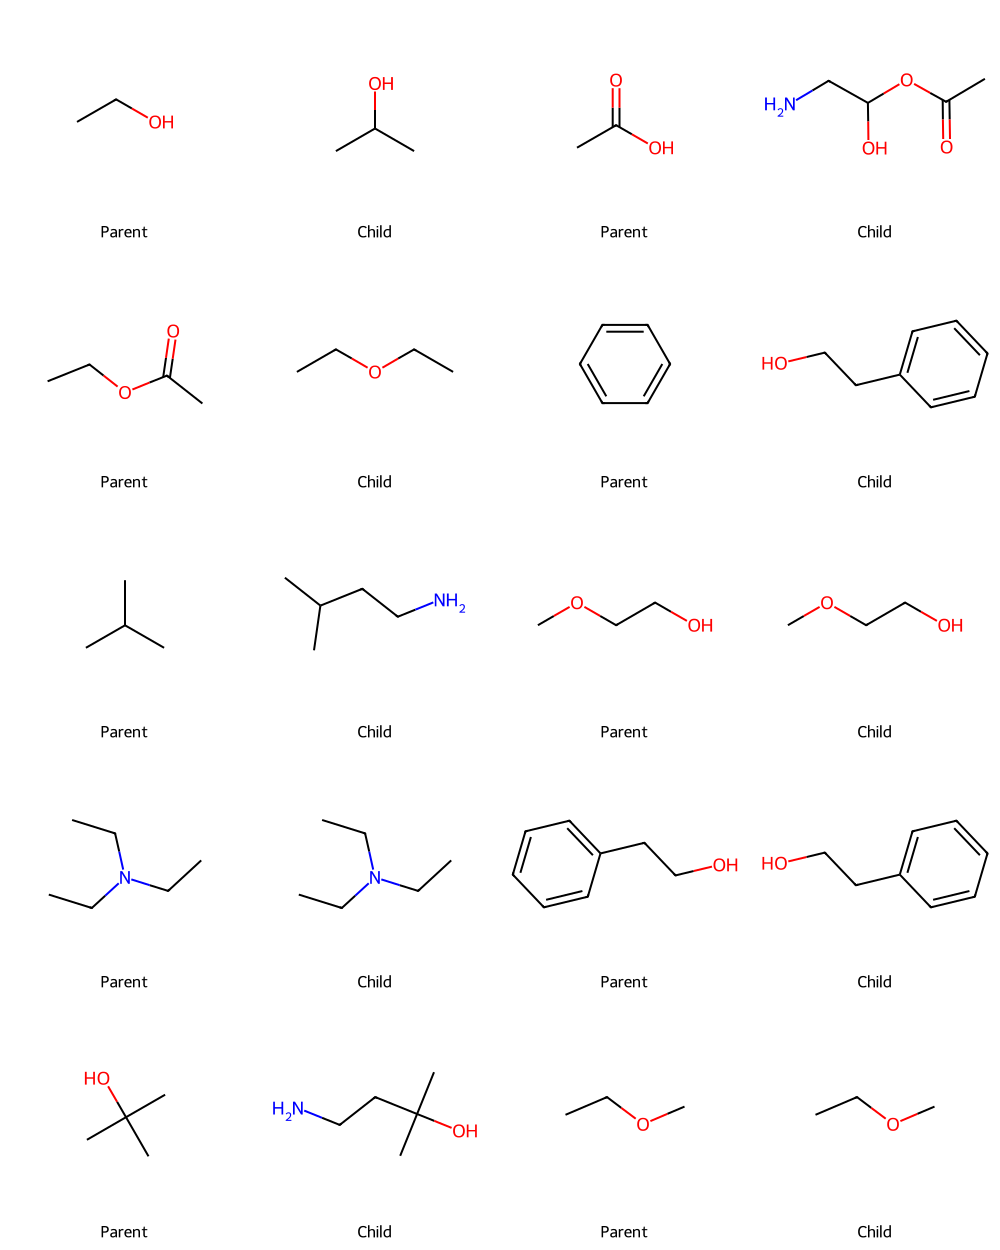

Mutations: Parent → Child

=== Crossovers (A + B → Child) ===
CCOC(=O)CC + CCNCCO → CCOCC
c1ccccc1CCO + CC(=O)OCC → OCCc1ccccc1
CC(C)CCO + OCCCO → CC(C)CC(O)C(O)CCO
COCCO + CCOC(=O)C → CCOC
CCN(CC)CC + CCOC(=O)CC → CCC(=O)OC(=O)CC
COc1ccccc1CC + NCCO → COc1ccccc1OC
CC(C)(C)OC(=O)C + CCO → CC(=O)OC(C)(C)C
c1ccccc1CCO + CCNCCO → OCCc1ccccc1
CC(C)CO + CC(=O)OCC → CCOC(C)=O
CCOCC + NCCOC(=O)C → CCOCC


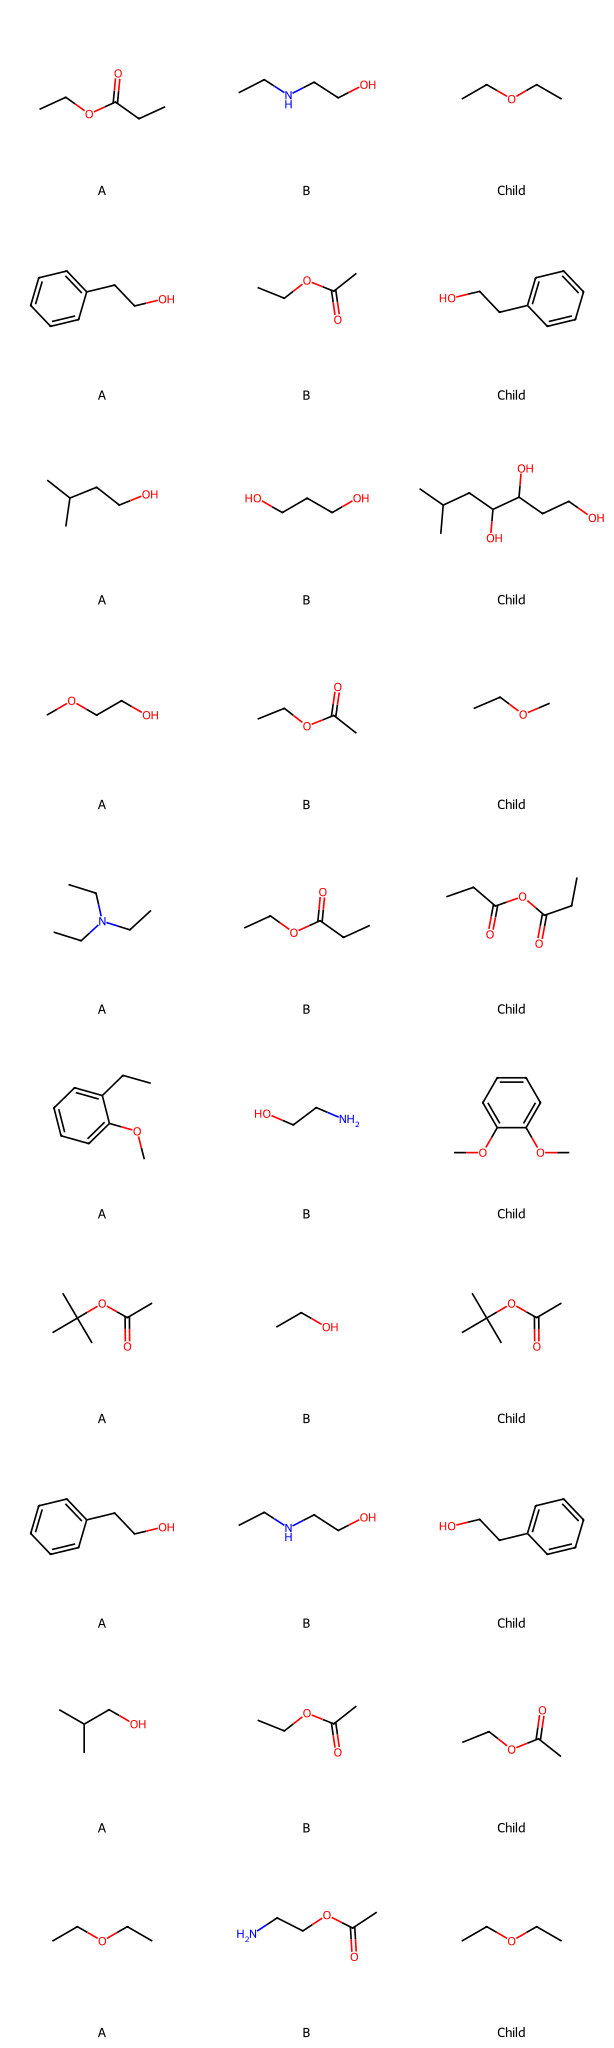

Crossovers: A, B, Child


In [ ]:
# ==== Experiments: 10 mutations + 10 crossovers ====
set_rng(123)

# Fragment pool (tweak as you like)
fragment_pool = [
    "C","CC","CCC","O","CO","N","CN",
    "CCO","CC(=O)O","CCOC(=O)C","c1ccccc1",
    "CCNCCO","NCCO","CCOCC","CCOC(=O)CC"
]

# Pick 10 mutation parents (mix tiny/aliphatic/aromatic)
mutation_parents = [
    "CCO","CC(=O)O","CCOC(=O)C","c1ccccc1","CC(C)C",
    "COCCO","CCN(CC)CC","c1ccccc1CCO","CC(C)(C)O","CCOC"
]

mutation_children = []
print("=== Mutations (Parent → Child) ===")
for smi in mutation_parents:
    child = brics_mutate(smi, fragment_pool, p_insert=0.6, max_tries=128)
    mutation_children.append(child)
    print(f"{smi} → {child}")
show_mutation_pairs(mutation_parents, mutation_children, title="Mutations: Parent → Child", mols_per_row=4)

# Choose 10 crossover pairs (longer variety)
crossover_pairs = [
    ("CCOC(=O)CC", "CCNCCO"),
    ("c1ccccc1CCO", "CC(=O)OCC"),
    ("CC(C)CCO", "OCCCO"),
    ("COCCO", "CCOC(=O)C"),
    ("CCN(CC)CC", "CCOC(=O)CC"),
    ("COc1ccccc1CC", "NCCO"),
    ("CC(C)(C)OC(=O)C", "CCO"),
    ("c1ccccc1CCO", "CCNCCO"),
    ("CC(C)CO", "CC(=O)OCC"),
    ("CCOCC", "NCCOC(=O)C"),
]

crossover_children = []
print("\n=== Crossovers (A + B → Child) ===")
for a, b in crossover_pairs:
    child = brics_crossover_simple(a, b, max_tries=128)
    crossover_children.append(child)
    print(f"{a} + {b} → {child}")
show_crossover_triplets(crossover_pairs, crossover_children, title="Crossovers: A, B, Child", mols_per_row=3)


In [ ]:
# --- Minimal, chemistry-ready SDA/GA runner (works for strings or SMILES) ---

class PatternInstance:
    def __init__(self, pattern, creation_time, expiration_time):
        self.pattern = pattern
        self.creation_time = creation_time
        self.expiration_time = expiration_time
    def is_expired(self, current_time):
        return current_time >= self.expiration_time

def run_simulation(
    base_elements,                    # list[str]: 'A','B','C' or SMILES fragments/molecules
    stability,                        # CALLABLE: stability(pattern)->int (expiration lifetime)
    replenishment_rate=5,
    interactions_per_gen=50,
    generations=10,
    selection_mode="uniform",         # uniform over instances; roulette emerges via persistence
    name="SDA/GA",
    init_pop=None,
    init_hist=None,
    seed=42,
    use_recomb=False,
    mutation_prob=0.0,
    recombine=None,                   # function(p1:str,p2:str)->str
    mutate=None,                      # function(s:str, base_elements:list[str], prob:float)->str
    validate_fn=None,                 # OPTIONAL: function(s:str)->bool, e.g., RDKit plausibility
    max_len=50                        # simple guard; for SMILES you can keep or replace with atom-count
):
    """
    Minimal changes from your original:
      - 'stability' must be a callable stability_fn(pattern)->int (no 'unconstrained' mode).
      - optional 'validate_fn' to drop invalid children (e.g., RDKit sanitization).
      - default selection is 'uniform' (emergent roulette via persistence), but your old
        'frequency_proportional' option still works if you want it.
      - recombine/mutate are injected, so you can plug your RDKit/BRICS ops directly.
    """
    import numpy as np, random
    from collections import Counter
    random.seed(seed); np.random.seed(seed)

    assert callable(stability), "Pass a callable stability(pattern)->int"
    stability_function = stability

    # Initialize population
    population = [] if init_pop is None else init_pop
    if init_pop is None:
        for element in base_elements:
            s = int(max(1, stability_function(element)))
            for _ in range(replenishment_rate):
                population.append(PatternInstance(element, 0, s))
    else:
        for p in population:
            p.expiration_time -= p.creation_time

    # History
    history = {} if init_hist is None else init_hist
    history.setdefault('populations', [])
    history.setdefault('entropy', [])
    history.setdefault('total_counts', [])
    history.setdefault('pattern_counts', [])

    # Main loop
    for t in range(1, generations + 1):
        # 1) Remove expired
        population = [p for p in population if not p.is_expired(t)]

        # 2) Replenish base elements (SDA replenishment stays the same)
        for element in base_elements:
            s = int(max(1, stability_function(element)))
            for _ in range(replenishment_rate):
                population.append(PatternInstance(element, t, t + s))

        # 3) Interactions
        if population and len(population) >= 2:
            # pattern distribution snapshot (for frequency_proportional option)
            pattern_types = [p.pattern for p in population]
            pattern_counts = Counter(pattern_types)

            for _ in range(interactions_per_gen):
                # Parent selection (uniform over instances by default)
                if selection_mode == "frequency_proportional":
                    chosen = random.choices(
                        list(pattern_counts.keys()),
                        weights=[pattern_counts[p] for p in pattern_counts],
                        k=2
                    )
                    p1_pat, p2_pat = chosen
                    p1_pool = [p for p in population if p.pattern == p1_pat]
                    p2_pool = [p for p in population if p.pattern == p2_pat]
                    p1 = random.choice(p1_pool)
                    if p1_pat == p2_pat and len(p1_pool) > 1:
                        p2_pool.remove(p1)
                    p2 = random.choice(p2_pool) if p2_pool else p1
                else:
                    p1, p2 = random.sample(population, 2)

                # Variation: concat OR recombine(+optional mutate)
                if use_recomb and callable(recombine):
                    child = recombine(p1.pattern, p2.pattern)
                    if child is not None and random.random() <= mutation_prob: # Add check for None
                        child = mutate(child, base_elements=base_elements)
                else:
                    child = p1.pattern + p2.pattern

                # Basic guard (you can replace with atom-count if using RDKit)
                if max_len is not None and len(child) > max_len:
                    continue

                # Optional chemical plausibility check
                if validate_fn is not None and not validate_fn(child):
                    continue

                # Assign expiration (persistence) via stability function
                s_child = int(max(1, stability_function(child)))
                population.append(PatternInstance(child, t, t + s_child))

        # 4) Metrics
        from collections import Counter
        counts = Counter(p.pattern for p in population)
        total = len(population)
        if total > 0:
            probs = [c / total for c in counts.values()]
            import math
            entropy = -sum(p * math.log(p, 2) for p in probs if p > 0)
        else:
            entropy = 0.0

        history['entropy'].append(entropy)
        history['pattern_counts'].append(len(counts))
        history['total_counts'].append(total)
        history['populations'].append(dict(counts))

    return {
        'name': name,
        'history': history,
        'final_population': dict(counts),
        'final_raw_population': population
    }

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors as rdMD

def validate_fn(smiles: str) -> bool:
    try:
        m = Chem.MolFromSmiles(smiles, sanitize=True)
        return m is not None
    except Exception:
        return False

def stability_fn_basic(smiles: str) -> int:
    m = Chem.MolFromSmiles(smiles)
    if m is None: return 1
    ha = sum(1 for a in m.GetAtoms() if a.GetAtomicNum() > 1)  # heavy atoms
    return max(1, 5 + ha)


def stability_fn_biased(smiles: str, S_min=1, S_max=40) -> int:
   # bumps for rings/aromaticity and H-bond capacity; mild penalty for high flexibility, charge, and very large species
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return S_min

    # Descriptors (all O(1) time for small molecules)
    ha   = sum(1 for a in m.GetAtoms() if a.GetAtomicNum() > 1)         # heavy atoms
    rings_aro  = rdMD.CalcNumAromaticRings(m)
    rings_al   = rdMD.CalcNumAliphaticRings(m)
    hbd  = rdMD.CalcNumHBD(m)
    hba  = rdMD.CalcNumHBA(m)
    rot  = rdMD.CalcNumRotatableBonds(m)
    fc   = sum(abs(a.GetFormalCharge()) for a in m.GetAtoms())

    # Base: small size trend (your original idea)
    score = 5 + 0.8*ha

    # Plausibility bumps (very small)
    score += 1.0*rings_aro + 0.5*min(2, rings_al)
    score += 0.25*min(4, hbd + hba)           # modest benefit for heteroatom functionality

    # Penalties
    score -= 0.3*min(10, rot)                 # very floppy chains decay faster
    score -= 1.0*min(2, fc)                   # charged species less persistent in neutral env
    if ha > 30: score -= 0.5*(ha-30)          # discourage runaway growth

    # Map to an integer lifetime, gently clipped
    S = int(round(score))
    return max(S_min, min(S_max, S))


stability_fn = stability_fn_biased

In [ ]:
base_elements = [
    "C","CC","CCC","O","CO","N","CN",
    "CCO","CC(=O)O","CCOC(=O)C","c1ccccc1",
    "CCNCCO","NCCO","CCOCC","CCOC(=O)CC",
]

result = run_simulation(
    base_elements=base_elements,            # e.g., small fragment pool
    stability=stability_fn,                 # callable
    replenishment_rate=5,
    interactions_per_gen=200,
    generations=1000,
    selection_mode="uniform",               # emergent roulette via persistence
    use_recomb=True,
    mutation_prob=0.01,
    recombine=brics_crossover_simple,
    mutate=brics_mutate,
    validate_fn=validate_fn,
    max_len=None                            # disable string-length guard if using validate_fn
)


In [ ]:
base_set = set(base_elements)
final = result['final_population']
base_counts  = {k:v for k,v in final.items() if k in base_set}
novel_counts = {k:v for k,v in final.items() if k not in base_set}

# quick summaries
def top_n(d, n=15):
    return sorted(d.items(), key=lambda kv: kv[1], reverse=True)[:n]

print("Top novel (not in base):")
for k,v in top_n(novel_counts, 15): print(f"  {k}: {v}")

print("\nShare novel vs base:")
tot = sum(final.values())
print(f"  novel: {sum(novel_counts.values())/tot:.2%}, base: {sum(base_counts.values())/tot:.2%}")


Top novel (not in base):
  CCCC(O)C(O)C(O)(OC(O)OC)C(N)CCC: 1895
  CCCC(O)C(O)C(O)(OC(O)(C(N)CCC)C(O)C(O)CCC)C(N)CCC: 629
  CCCC(O)C(O)C(O)(OCO)C(N)CCC: 254
  CCCC(O)C(O)C(O)(NC(O)(C(N)CCC)C(O)C(O)CCC)C(N)CCC: 215
  CCOC(O)OC: 110
  CCC(=O)OC(O)OC: 62
  COC(O)OCCO: 55
  CCCC(O)C(O)C(O)(OCC)C(N)CCC: 52
  COC(O)OC(C)=O: 49
  CCCC(O)C(O)C(O)(OC(C)=O)C(N)CCC: 32
  CCCC(O)C(O)C(O)(OC(=O)CC)C(N)CCC: 25
  CCCC(O)C(O)C(O)(NCC)C(N)CCC: 25
  CCCC(O)C(O)C(O)(OCCO)C(N)CCC: 22
  CC(=O)OC(C)=O: 20
  CCCC(O)C(O)C(O)(NCCO)C(N)CCC: 19

Share novel vs base:
  novel: 84.65%, base: 15.35%


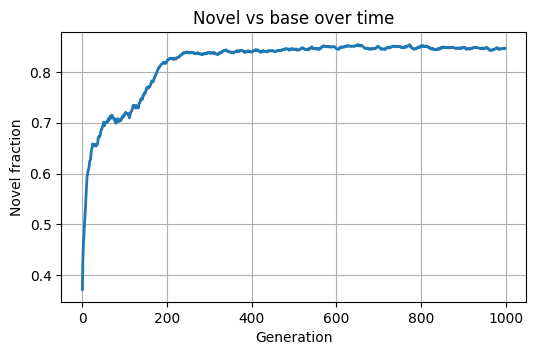

In [ ]:
novel_frac = []
for pop in result['history']['populations']:
    tot = sum(pop.values())
    novel = sum(cnt for smi, cnt in pop.items() if smi not in base_set)
    novel_frac.append(novel / tot if tot else 0.0)

plt.figure(figsize=(6,3.5))
plt.plot(novel_frac, lw=2)
plt.xlabel('Generation'); plt.ylabel('Novel fraction')
plt.title('Novel vs base over time'); plt.grid(True)


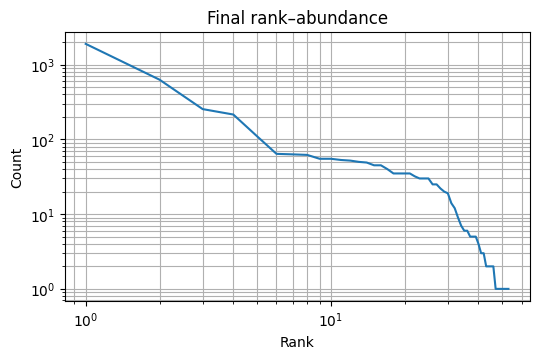

In [ ]:
final = result['final_population']
abund = sorted(final.values(), reverse=True)
plt.figure(figsize=(6,3.5))
plt.plot(range(1, len(abund)+1), abund)
plt.xlabel('Rank'); plt.ylabel('Count')
plt.title('Final rank–abundance'); plt.xscale('log'); plt.yscale('log'); plt.grid(True, which='both')


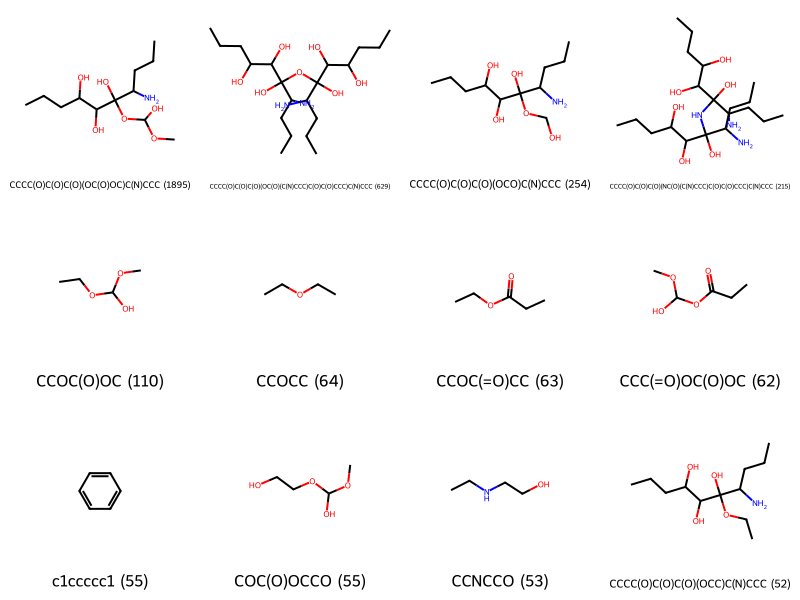

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

def plot_top_molecule_grid(result, top_n=12, mols_per_row=4):
    counts = Counter(result['final_population'])
    top = counts.most_common(top_n)
    smiles = [s for s,_ in top]
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    legends = [f"{s} ({c})" for s,c in top]
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(200,200),
                               legends=legends, useSVG=False)
    return img

plot_top_molecule_grid(result, top_n=12)


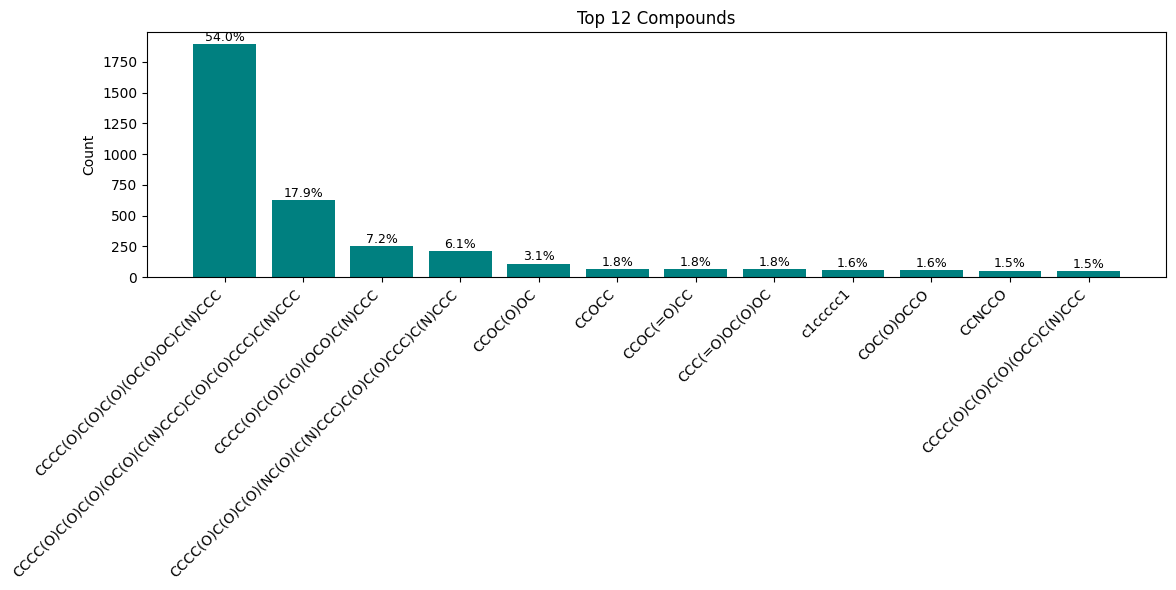

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_top_compounds(result, top_n=10):
    counts = Counter(result['final_population'])
    top = counts.most_common(top_n)

    smiles, freqs = zip(*top)
    total = sum(freqs)

    plt.figure(figsize=(12,6))
    bars = plt.bar(range(len(smiles)), freqs, color="teal")
    plt.xticks(range(len(smiles)), smiles, rotation=45, ha='right', fontsize=10)
    plt.ylabel("Count")
    plt.title(f"Top {top_n} Compounds")

    # percentage labels
    for i, bar in enumerate(bars):
        pct = 100*freqs[i]/total
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
                 f"{pct:.1f}%", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_top_compounds(result, top_n=12)


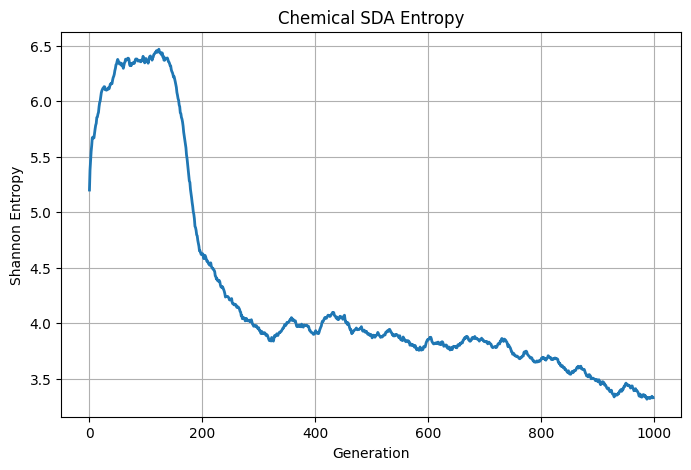

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_entropy(population_counts):
    """Compute Shannon entropy from a dict {pattern: count}."""
    total = sum(population_counts.values())
    if total == 0:
        return 0.0
    probs = np.array(list(population_counts.values())) / total
    return -np.sum([p * np.log2(p) for p in probs if p > 0])

def plot_entropy(history, title="Entropy over time"):
    plt.figure(figsize=(8,5))
    plt.plot(history['entropy'], lw=2)
    plt.xlabel("Generation")
    plt.ylabel("Shannon Entropy")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example: after your simulation run
entropies = [compute_entropy(pop) for pop in result['history']['populations']]
result['history']['entropy'] = entropies

plot_entropy(result['history'], title="Chemical SDA Entropy")


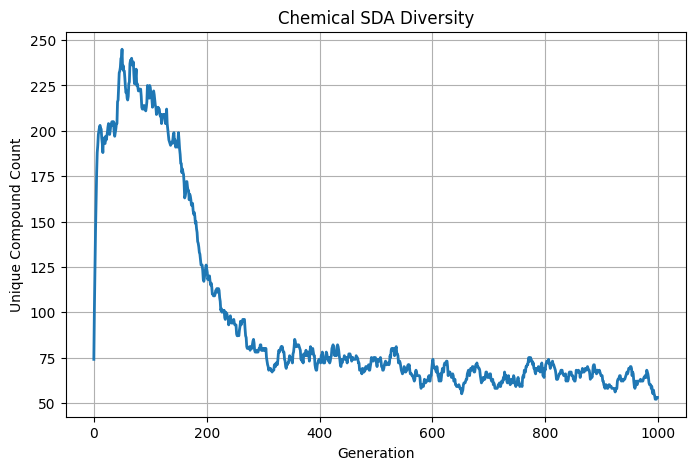

In [ ]:
import matplotlib.pyplot as plt

def plot_chemical_diversity(result, title="Chemical SDA Diversity"):
    """
    Plot unique compound count (diversity) over generations.
    result: output of run_simulation
    """
    history = result['history']
    diversity = history['pattern_counts']  # already tracked in run_simulation

    plt.figure(figsize=(8,5))
    plt.plot(diversity, linewidth=2)
    plt.xlabel("Generation")
    plt.ylabel("Unique Compound Count")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage
plot_chemical_diversity(result, title="Chemical SDA Diversity")



=== Generation 200 (total=3747) ===
  #1: CCCC(O)C(O)C(O)(NCN)C(N)CCC   count=657   share=17.5%
  #2: CCCC(O)C(O)C(O)(OCO)C(N)CCC   count=545   share=14.5%

=== Generation 600 (total=4345) ===
  #1: CCCC(O)C(O)C(O)(OC(O)(C(N)CCC)C(O)C(O)CCC)C(N)CCC   count=1030   share=23.7%
  #2: CCCC(O)C(O)C(O)(OCO)C(N)CCC   count=847   share=19.5%

=== Generation 1000 (total=4203) ===
  #1: CCCC(O)C(O)C(O)(OC(O)OC)C(N)CCC   count=1895   share=45.1%
  #2: CCCC(O)C(O)C(O)(OC(O)(C(N)CCC)C(O)C(O)CCC)C(N)CCC   count=629   share=15.0%


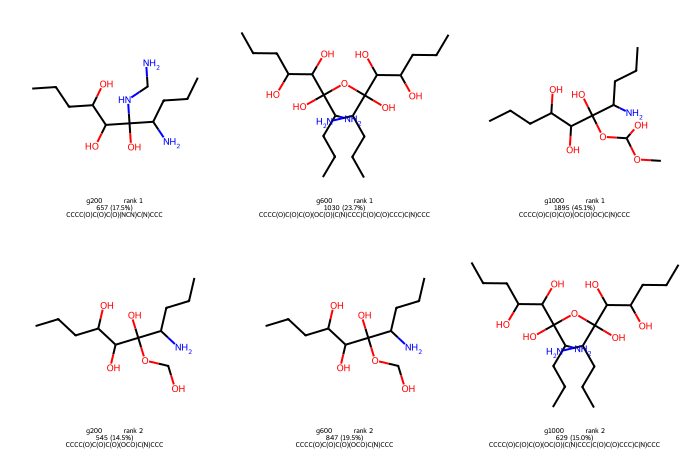

In [ ]:
# Top-5 snapshots every 100 generations + 6x5 structure panel

from collections import Counter
import math
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def top_k_at_gen(history_populations, gen, k=3):
    """
    Return top-k (smiles, count, pct) at 1-based generation `gen`.
    history_populations: list[dict], as in result['history']['populations']
    """
    idx = gen - 1  # history stores t=1..T at indices 0..T-1
    pop = history_populations[idx]
    total = sum(pop.values()) if pop else 0
    top = sorted(pop.items(), key=lambda kv: kv[1], reverse=True)[:k]
    top = [(s, c, (100.0 * c / total) if total > 0 else 0.0) for s, c in top]
    return top, total

def make_panel_image(result, gens=(100,200,300,400,500,600,700,800,900,1000), k=3, mols_per_row=10, sub_img_size=(230,230)):
    """
    Build a 6x5 grid: columns = generations (len(gens)=6), rows = rank 1..k.
    Cell (row r, col c) is the r-th most abundant compound at generation gens[c].
    """
    hist = result['history']['populations']
    # Collect per-gen top-k
    per_gen = {}
    for g in gens:
        tk, total = top_k_at_gen(hist, g, k=k)
        per_gen[g] = (tk, total)

    # Prepare mols and legends row-major by rank (rows) then generation (cols)
    mols, legends = [], []
    for rank in range(k):  # row = rank 0..k-1
        for g in gens:    # col = each snapshot gen
            tk, total = per_gen[g]
            if rank < len(tk):
                smi, cnt, pct = tk[rank]
                m = Chem.MolFromSmiles(smi)
                mols.append(m if m is not None else Chem.MolFromSmiles(""))
                legends.append(f"g{g} • rank {rank+1}\n{cnt} ({pct:.1f}%)\n{smi}")
            else:
                # pad if fewer than k species exist
                mols.append(Chem.MolFromSmiles(""))
                legends.append(f"g{g} • rank {rank+1}\n—")

    # RDKit draws row-major; with molsPerRow=6 this yields 5 rows × 6 cols
    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=len(gens),
        subImgSize=sub_img_size,
        legends=legends,
        useSVG=False
    )
    return img, per_gen

# ==== Run on your last 'result' ====

gens = (200, 600, 1000)
panel_img, per_gen = make_panel_image(result, gens=gens, k=2, mols_per_row=5)

# Print the top-5 tables
for g in gens:
    tk, total = per_gen[g]
    print(f"\n=== Generation {g} (total={total}) ===")
    for i, (smi, cnt, pct) in enumerate(tk, start=1):
        print(f"  #{i}: {smi}   count={cnt}   share={pct:.1f}%")

# Show the panel
display(panel_img)


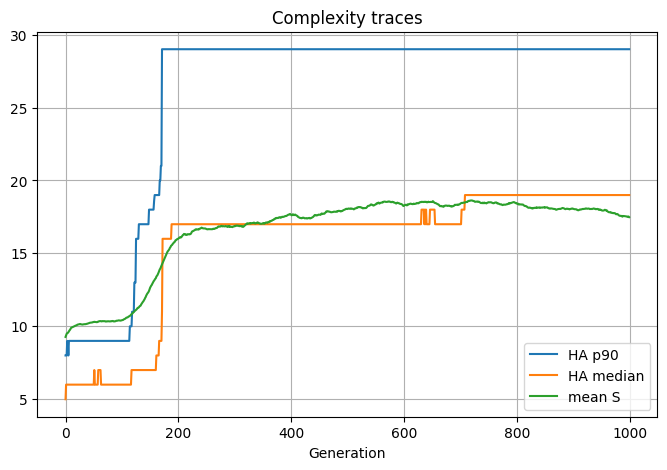

In [ ]:
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt

def heavy_atoms(smi):
    m = Chem.MolFromSmiles(smi)
    if not m: return 0
    return sum(1 for a in m.GetAtoms() if a.GetAtomicNum()>1)

p90, med, meanS = [], [], []
for pop in result['history']['populations']:
    if not pop: p90.append(0); med.append(0); meanS.append(0); continue
    counts = []
    Ss = []
    for smi,c in pop.items():
        ha = heavy_atoms(smi)
        counts += [ha]*c
        Ss += [stability_fn(smi)]*c
    counts = np.array(counts) if counts else np.array([0])
    p90.append(float(np.percentile(counts,90)))
    med.append(float(np.median(counts)))
    meanS.append(float(np.mean(Ss)))
plt.figure(figsize=(8,5)); plt.plot(p90,label='HA p90'); plt.plot(med,label='HA median'); plt.plot(meanS,label='mean S');
plt.xlabel('Generation'); plt.title('Complexity traces'); plt.legend(); plt.grid(True); plt.show()
